Picoscopeを用いて、超音波による計測データを処理したい。しかし、.psdataファイルはほかのソフトで読むことができない。そのため、.matで変換する必要がある。
一方で、ファイルを一つ一つ手作業で変換していくのは手間なので、シェルスクリプトの作成が臨まれる。コマンドとしては、picoscopeがインストールされたPCで`picoscope /c P20240911-1054.psdata /f mat /d Z:\tmp\P20240911-1054.mat /q /b 1`を基礎としてシェルスクリプトに変換するとよい。そのファイルがある場所でしか実行できないことに注意。よって、実行の際は  
コマンドでそのディレクトリまで移動
Start-Process -FilePath "C:\Program Files\Pico Technology\PicoScope 7 T&M Stable\PicoScope.exe" -ArgumentList "BatchConvert", "W:\2024\0730", "Z:\tmp", ".mat" -Wait -NoNewWindow
→コマンド実行
→保存
を繰り返すこととなる。一つのファイルを変換し、所定の場所に保存するのには大体一つのファイルあたり5分かかる計算。

In [12]:
import numpy as np
import scipy.io as sio
def inspect_mat_file(file_path):
    """
    .matファイルの構造を詳細に表示する関数
    """
    print(f"=== {file_path} の解析 ===")
    mat_data = sio.loadmat(file_path)
    
    print("\n1. データ構造:")
    print("\nキー一覧:")
    for key in mat_data.keys():
        print(f"- {key}")
    print(mat_data['Tinterval'])
    for key in mat_data.keys():
        if not key.startswith('__'):  # システム変数を除外
            print(f"\n【キー: {key}】")
            data = mat_data[key]
            
            # 基本情報の表示
            print(f"▶ 型: {type(data)}")
            #print(f"▶ 形状: {data.shape}")
            #print(f"▶ データ型: {data.dtype}")
            
            # ネストされた構造の場合の詳細表示
            if isinstance(data, np.ndarray):
                if data.dtype.names:  # 構造体の場合
                    print("▶ 構造体フィールド:")
                    for field_name in data.dtype.names:
                        field_data = data[field_name][0,0]
                        print(f"    - {field_name}:")
                        print(f"      型: {type(field_data)}")
                        print(f"      形状: {field_data.shape}")
                        print(f"      データ型: {field_data.dtype}")
                
                # データの一部を表示
                if data.size > 0:
                    print("▶ データサンプル:")
                    try:
                        if data.size > 5:
                            print(f"    先頭5要素: {data.flatten()[:5]}")
                        else:
                            print(f"    データ: {data}")
                    except:
                        print("    ※データの表示に失敗しました")

    print("\n2. メタデータ:")
    for key in mat_data.keys():
        if key.startswith('__'):
            print(f"▶ {key}: {mat_data[key]}")

# 使用例
file_path = '/mnt/sdb/matsubara/raw_singal/P20240726-1601.mat'
inspect_mat_file(file_path)

=== /mnt/sdb/matsubara/raw_singal/P20240726-1601.mat の解析 ===

1. データ構造:

キー一覧:
- Tstart
- Tinterval
- ExtraSamples
- RequestedLength
- Length
- A
- B
- C
- D
- Version
[[1.91999998e-08]]

【キー: Tstart】
▶ 型: <class 'numpy.ndarray'>
▶ データサンプル:
    データ: [[0.]]

【キー: Tinterval】
▶ 型: <class 'numpy.ndarray'>
▶ データサンプル:
    データ: [[1.91999998e-08]]

【キー: ExtraSamples】
▶ 型: <class 'numpy.ndarray'>
▶ データサンプル:
    データ: [[0]]

【キー: RequestedLength】
▶ 型: <class 'numpy.ndarray'>
▶ データサンプル:
    データ: [[260416669]]

【キー: Length】
▶ 型: <class 'numpy.ndarray'>
▶ データサンプル:
    データ: [[260416669]]

【キー: A】
▶ 型: <class 'numpy.ndarray'>
▶ データサンプル:
    先頭5要素: [-0.05870841 -0.03131115 -0.01565558 -0.01956947 -0.01565558]

【キー: B】
▶ 型: <class 'numpy.ndarray'>
▶ データサンプル:
    先頭5要素: [-0.01565558 -0.01956947 -0.00391389 -0.00782779 -0.01956947]

【キー: C】
▶ 型: <class 'numpy.ndarray'>
▶ データサンプル:
    先頭5要素: [0.02935421 0.01956947 0.00978474 0.01956947 0.        ]

【キー: D】
▶ 型: <class 'numpy.ndarray'>
▶ データサンプル:
    先頭5要素:

Available keys in file:
- Tstart: shape=(1, 1)
- Tinterval: shape=(1, 1)
- ExtraSamples: shape=(1, 1)
- RequestedLength: shape=(1, 1)
- Length: shape=(1, 1)
- A: shape=(260416669, 1)
- B: shape=(260416669, 1)
- C: shape=(260416669, 1)
- D: shape=(260416669, 1)
- Version: shape=(12,)
Using channel: A
Sampling rate from file: 52.1 MHz


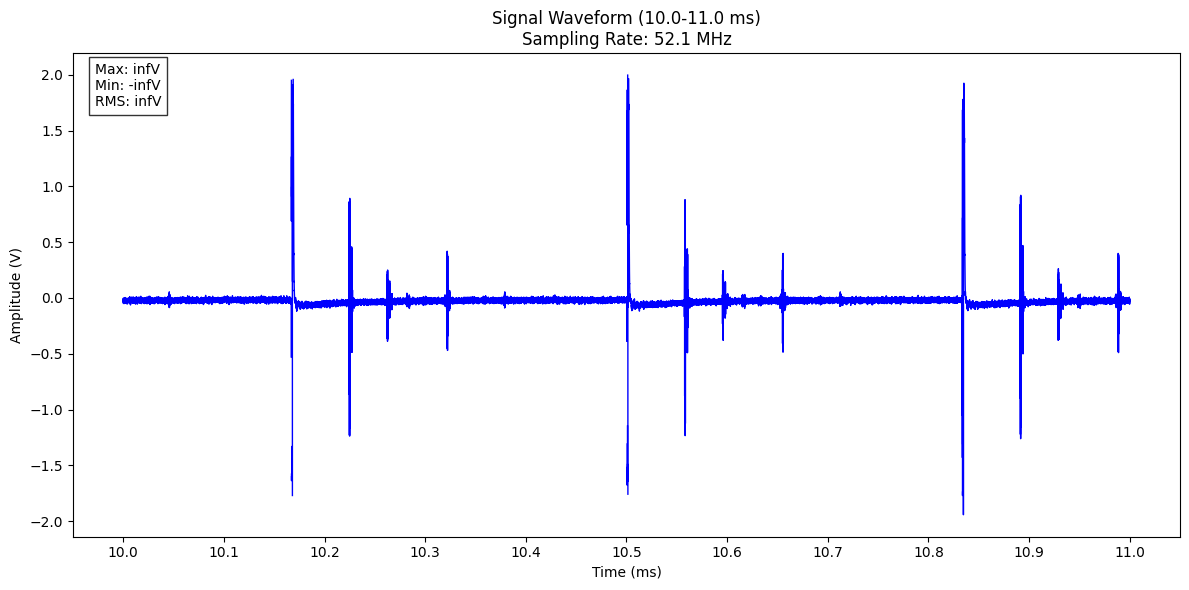

In [ ]:
import scipy.io as sio
def plot_signal_waveform(file_path, start_ms=0, end_ms=100):
    """
    Display signal waveform from .mat file
    
    Parameters:
    -----------
    file_path : str
        Path to .mat file
    start_ms : float 
        Start time (milliseconds)
    end_ms : float
        End time (milliseconds)
    """
    # Load and inspect data
    mat_data = sio.loadmat(file_path)
    
    # Display available keys
    print("Available keys in file:")
    for key in mat_data.keys():
        if not key.startswith('__'):
            print(f"- {key}: shape={mat_data[key].shape}")
    
    # Try different possible channel names
    channel_names = ['TDX1', 'A', 'B', 'Channel_A', 'Channel_1']
    signal = None
    
    for name in channel_names:
        if name in mat_data:
            signal = mat_data[name].flatten()
            print(f"Using channel: {name}")
            break
    
    if signal is None:
        raise ValueError("No valid channel found in the file")
    
    # Get sampling frequency
    if 'Tinterval' in mat_data:
        sampling_interval = mat_data['Tinterval'][0][0]  # sampling interval (s)
        sampling_rate = 1 / sampling_interval
        print(f"Sampling rate from file: {sampling_rate/1e6:.1f} MHz")
    else:
        print("Warning: Sampling rate not found, using default 62.5MHz")
        sampling_rate = 62.5e6  # Hz
    
    # Generate time axis (milliseconds)
    time_ms = np.arange(len(signal)) / sampling_rate * 1000
    
    # Limit display range
    mask = (time_ms >= start_ms) & (time_ms <= end_ms)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(time_ms[mask], signal[mask], 'b-', linewidth=1)
    #plt.grid(True, which='both')
    #plt.minorticks_on()
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (V)')
    plt.title(f'Signal Waveform ({start_ms:.1f}-{end_ms:.1f} ms)\nSampling Rate: {sampling_rate/1e6:.1f} MHz')
    
    # Set x-axis ticks
    tick_interval = 0.1  # 0.1ms intervals
    plt.xticks(np.arange(start_ms, end_ms+tick_interval, tick_interval))
    
    # Display statistics
    signal_section = signal[mask]
    plt.text(0.02, 0.98, 
             f'Max: {np.max(signal_section):.3f}V\n'
             f'Min: {np.min(signal_section):.3f}V\n'
             f'RMS: {np.sqrt(np.mean(signal_section**2)):.3f}V',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

# Run analysis
#file_path = '/mnt/sdb/matsubara/tmp/sensor_data.mat'
file_path = '/mnt/sdb/matsubara/raw_singal/P20240726-1601.mat'
plot_signal_waveform(file_path, start_ms=10, end_ms=11)

Available keys in file:
- Tstart: shape=(1, 1)
- Tinterval: shape=(1, 1)
- ExtraSamples: shape=(1, 1)
- RequestedLength: shape=(1, 1)
- Length: shape=(1, 1)
- A: shape=(260416669, 1)
- B: shape=(260416669, 1)
- C: shape=(260416669, 1)
- D: shape=(260416669, 1)
- Version: shape=(12,)
Using channel: A
Sampling rate from file: 52.1 MHz


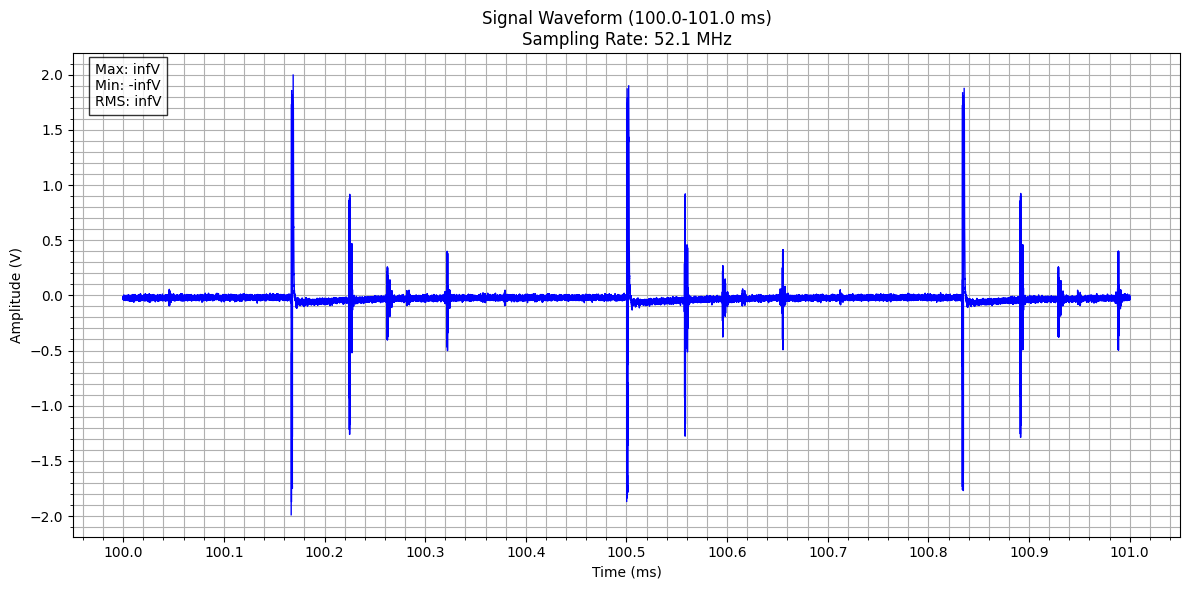

Loading data...
loading success
Found 15 triggered pulses


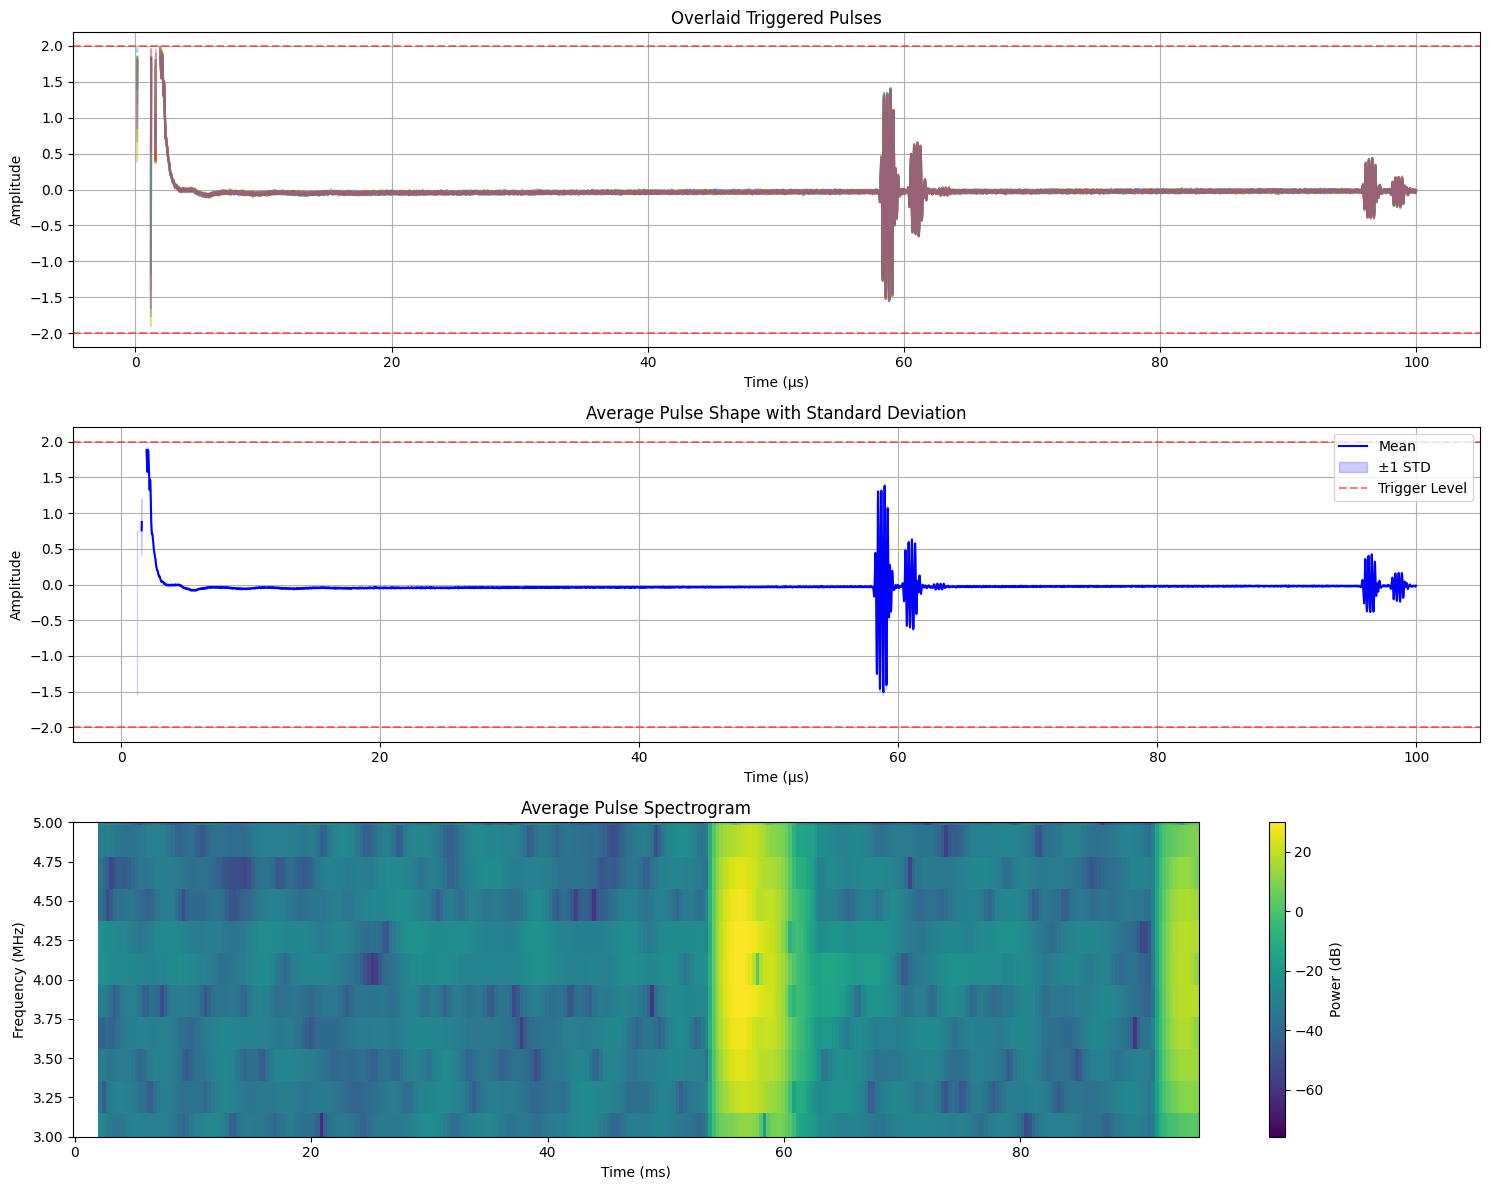

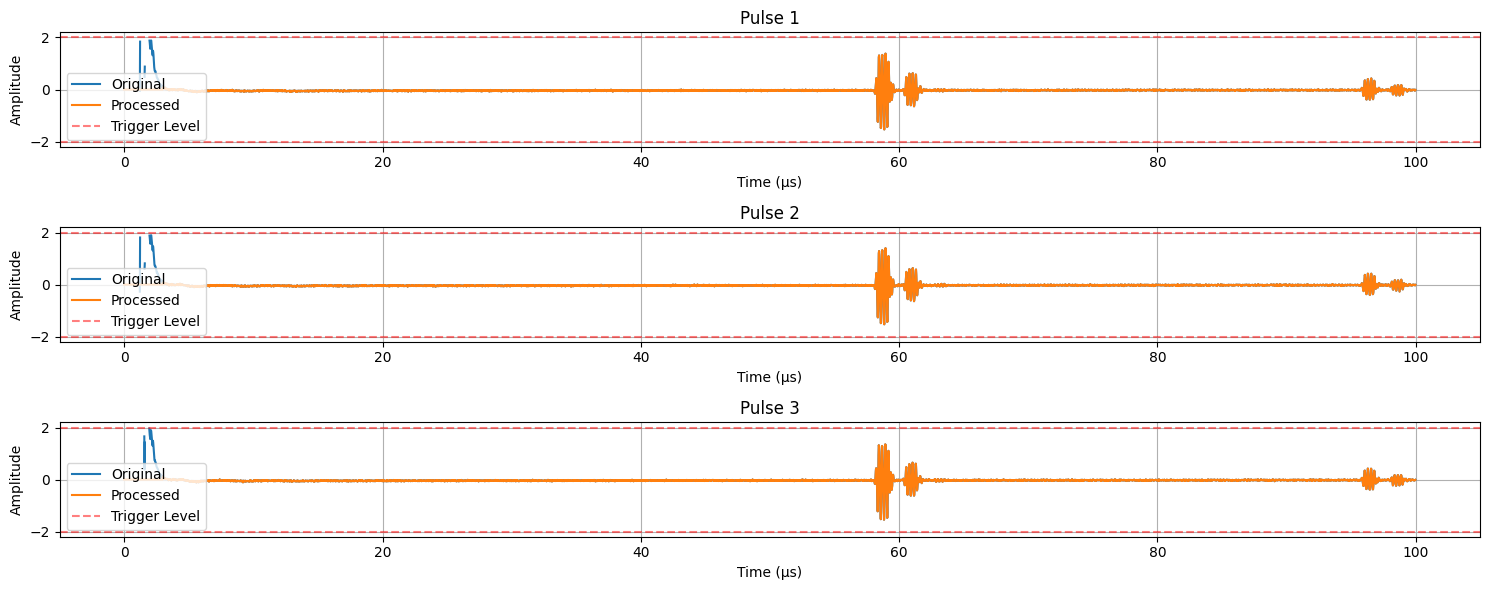

In [7]:
import numpy as np
import scipy.io as sio
import torch
import matplotlib.pyplot as plt
from scipy import signal

def extract_amplitude_triggered_pulses(file_path, start_time=0.444, duration=0.001, 
                                    window_width=50e-6, amplitude_threshold=2.0):
    """
    振幅が閾値に達した瞬間から一定時間の波形を切り出す関数
    
    Parameters:
    -----------
    file_path : str
        .matファイルのパス
    start_time : float
        開始時間（秒）
    duration : float
        解析時間幅（秒）
    window_width : float
        切り出す窓幅（秒）、デフォルト50μs
    amplitude_threshold : float
        トリガーとなる振幅閾値
    """
    # データ読み込み
    print("Loading data...")
    mat_data = sio.loadmat(file_path)
    print("loading success")
    signal_data = np.squeeze(mat_data["B"])
    Tinterval = float(mat_data['Tinterval'].item())
    Fs = 1.0 / Tinterval
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 指定時間範囲のデータ切り出し
    start_idx = int(start_time * Fs)
    duration_samples = int(duration * Fs)
    chunk = signal_data[start_idx:start_idx + duration_samples]
    
    # 振幅閾値を超えた位置の検出
    window_samples = int(window_width * Fs)
    trigger_points = []
    i = 0
    
    while i < len(chunk) - window_samples:
        if abs(chunk[i]) >= amplitude_threshold:
            trigger_points.append(i)
            i += window_samples  # 次のトリガー検索は window_width 秒後から
        else:
            i += 1
    
    # 各トリガーポイントからの波形切り出し
    # トリガーされたパルスを格納するリストを初期化
    triggered_pulses = []  # 生のパルスデータを格納
    triggered_pulses_processed = []  # 処理済みパルスデータを格納
    
    # 各トリガーポイントに対してパルスを切り出し
    for trigger in trigger_points:
        # トリガーポイントからwindow_samples秒分のパルスを切り出し
        if trigger + window_samples <= len(chunk):
            # パルスの切り出し
            pulse = chunk[trigger:trigger + window_samples]
            triggered_pulses.append(pulse)
            
            # 初期の反射波を除去（0-3μsまでの信号を0に設定）
            processed_pulse = pulse.copy()  # パルスのコピー作成
            zero_samples = int(3e-6 * Fs)  # 3μs分のサンプル数計算
            processed_pulse[:zero_samples] = 0  # 初期部分を0に設定
            triggered_pulses_processed.append(processed_pulse)
    
    # 検出されたパルス数を記録
    n_pulses = len(triggered_pulses)
    print(f"Found {n_pulses} triggered pulses")
    
    # 時間軸の生成（μs単位）
    pulse_time = np.arange(window_samples) * Tinterval * 1e6
    
    # プロット
    plt.figure(figsize=(15, 12))
    
    # 1. すべてのパルスを重ねて表示
    plt.subplot(3, 1, 1)
    for i, pulse in enumerate(triggered_pulses):
        plt.plot(pulse_time, pulse, alpha=0.5, label=f'Pulse {i+1}' if i < 5 else '')
    plt.axhline(y=amplitude_threshold, color='r', linestyle='--', alpha=0.5, label='Trigger Level')
    plt.axhline(y=-amplitude_threshold, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Time (μs)')
    plt.ylabel('Amplitude')
    plt.title('Overlaid Triggered Pulses')
    plt.grid(True)
    if n_pulses <= 5:
        plt.legend()
    
    # 2. 平均波形の表示
    mean_pulse = np.mean(triggered_pulses, axis=0)
    std_pulse = np.std(triggered_pulses, axis=0)
    
    plt.subplot(3, 1, 2)
    plt.plot(pulse_time, mean_pulse, 'b-', label='Mean')
    plt.fill_between(pulse_time, 
                    mean_pulse - std_pulse, 
                    mean_pulse + std_pulse, 
                    color='b', alpha=0.2, label='±1 STD')
    plt.axhline(y=amplitude_threshold, color='r', linestyle='--', alpha=0.5, label='Trigger Level')
    plt.axhline(y=-amplitude_threshold, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Time (μs)')
    plt.ylabel('Amplitude')
    plt.title('Average Pulse Shape with Standard Deviation')
    plt.grid(True)
    plt.legend()
    
    # 3. スペクトログラム（平均波形）
    n_fft = 256
    hop_length = n_fft // 16
    
    mean_pulse_torch = torch.from_numpy(mean_pulse).float().to(device)
    window = signal.windows.hann(n_fft)
    window_torch = torch.from_numpy(window).float().to(device)
    
    stft = torch.stft(
        input=mean_pulse_torch,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=n_fft,
        window=window_torch,
        center=False,
        normalized=False,
        onesided=True,
        return_complex=True
    )
    
    spectrogram = torch.abs(stft)**2
    spectrogram = spectrogram.cpu().numpy()
    
    plt.subplot(3, 1, 3)
    times_spec = np.arange(spectrogram.shape[1]) * hop_length / Fs * 1e6
    freqs = np.linspace(0, Fs/2, spectrogram.shape[0])
    plt.pcolormesh(times_spec, freqs/1e6, 10 * np.log10(spectrogram + 1e-10))
    plt.ylabel('Frequency (MHz)')
    plt.xlabel('Time (ms)')
    plt.title('Average Pulse Spectrogram')
    plt.ylim(3, 5)
    plt.colorbar(label='Power (dB)')
    
    plt.tight_layout()
    plt.show()
    
    # 個別パルスの表示（最大6つまで）
    n_display = min(3, n_pulses)
    if n_display > 0:
        plt.figure(figsize=(15, 2*n_display))
        for i in range(n_display):
            plt.subplot(n_display, 1, i+1)
            plt.plot(pulse_time, triggered_pulses[i], label='Original')
            plt.plot(pulse_time, triggered_pulses_processed[i], label='Processed')
            plt.axhline(y=amplitude_threshold, color='r', linestyle='--', alpha=0.5, label='Trigger Level')
            plt.axhline(y=-amplitude_threshold, color='r', linestyle='--', alpha=0.5)
            plt.xlabel('Time (μs)')
            plt.ylabel('Amplitude')
            plt.title(f'Pulse {i+1}')
            plt.grid(True)
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    return triggered_pulses, pulse_time, mean_pulse, std_pulse

# 使用例
file_path = '/mnt/sdb/matsubara/raw_singal/P20240726-1601.mat'
plot_signal_waveform(file_path, start_ms=100, end_ms=101)
pulses, time, mean_pulse, std_pulse = extract_amplitude_triggered_pulses(
    file_path,
    start_time=4.0, #秒, 計測の開始点
    duration=0.005, #秒, 計測時間
    window_width=100e-6, #3khzで照射しているので、パルスは1msに3回→0.1msごとに見ておけば次の計測に対応可能
    amplitude_threshold=2.0
)

In [6]:
import h5py

file_path = '/mnt/sdb/matsubara/tmp/sensor_data.mat'
with h5py.File(file_path, 'r') as f:
    # キー一覧を表示
    print(list(f.keys()))

    # たとえば、'data' というキーが含まれていれば
    data = f['sensor_data_cpu']  
    # ここで NumPy array として変換可能
    print(data.size)


['#refs#', 'sensor_data_cpu']


AttributeError: 'Group' object has no attribute 'size'

In [9]:

import h5py

file_path = '/mnt/sdb/matsubara/tmp/sensor_data_vertical.mat'
with h5py.File(file_path, 'r') as f:
    dataset_handle = f['sensor_data_cpu']  # HDF5 Datasetオブジェクト
    print(dataset_handle)  # <HDF5 dataset "sensor_data_cpu": shape=(..., ...), type="...">

    # NumPy配列に展開
    data_array = dataset_handle[:]  # または dataset_handle[()]

    # 配列の形・データ型・サイズなどを確認
    print(data_array.shape)
    print(data_array.dtype)
    print(data_array.size)



<HDF5 group "/sensor_data_cpu" (1 members)>


TypeError: Accessing a group is done with bytes or str, not <class 'slice'>

In [3]:
# データのロード
import numpy as np
data = np.load('/home/user01/Document/Matsubara/tmp/P20241119-1624_convert_all_channels_processed_data.npy', allow_pickle=True).item()
# 各チャンネルのデータにアクセス
tdx1_data = data['TDX1']
tdx2_data = data['TDX2']
tdx3_data = data['TDX3']
print(data.keys())
# 例：TDX2の処理済みパルスを取得
tdx2_processed_pulses = tdx2_data['processed_pulses']
for channel in result.keys():
    print(f"\n{channel}の処理結果:")
    print(f"検出されたパルス数: {len(result[channel]['pulses'])}")
    #print(f"サンプリングレート: {result[channel]['params']['sampling_rate']} Hz")

dict_keys(['TDX1', 'TDX2', 'TDX3'])

TDX1の処理結果:
検出されたパルス数: 5979
サンプリングレート: 52083333.842615336 Hz

TDX2の処理結果:
検出されたパルス数: 5980
サンプリングレート: 52083333.842615336 Hz

TDX3の処理結果:
検出されたパルス数: 0
サンプリングレート: 52083333.842615336 Hz


image.png

![](/home/user01/Document/Matsubara/sandbox/sensor.png)

In [2]:
from IPython.display import Video

Video("/home/user01/Document/Matsubara/output_gpu.mp4")